In [2]:
# import necesarry packages

import numpy as np
import scipy.stats as ss
from time import time

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

import seaborn as sns
sns.set()

from slice_sampler import *

# Slice Sampling

## Idea
The main idea of slice sampling is based on the observation that to sample from a distribution in $\mathfrak{R}^{n}$ whose density is proportional to $f(x)$, we can sample from the (n+1)-dimensional region that lies under the plot of $f(x)$ **uniformly**.

## Single variable slice sampling
The single variable slice sampling method replaces the current value,$x_0$, with a new variable $x_1$, found by a three step procedure as described below:

1. Draw $y\sim\text{Uniform}\left(0,f\left(x_{0}\right)\right)$ to define the horizontal slice $S=\left\{ x:y<f\left(x\right)\right\}$. Note that $x_0$ is always within $S$.
2. Find the interval $I=\left(L, R\right)$ around $x_0$ that contains at least a big part of the slice.
3. Draw the new point $x_1$ from the part of the slice within the interval which is acceptable.

### Finding the appropriate interval
The interval in step 2 $I=\left(L, R\right)$ needs to contain as much of the slice as feasible to allow the new point to differ as much as possible from the previous one. But on the other hand, we don't want it to be much larger than the slice, because it will result in proposing points that are not acceptable and a less efficient sampling method. We usually use an estimate $w$ for the scale of $S$ and randomly pick an initial interval of wise $w$ around $x_0$ and then expand it. Two well-know procedures for expanding the interval are "stepping out" and "doubling".

stepping out procedure: add $w$ to the end-points of the interval until both ends are out of the surface under $f$
doubling: double the interval from left or right randomly until both ends are out of the surface under $f$

### Sampling from the interval
After finding the appropriate interval, we can 

1. repeatedly sample uniformly from the the interval, until the proposed point is accepted
2. repeatedly sample uniformly from the interval and use the rejected points to shrink the interval, until the proposed point is accepted

### Acceptance condition
To be written


---
# Unimodal densities

Let's use slice sampling for a simple unimodal distribution like 1-dimensional Gaussian. Please note that as long as we can evaluate a function $f(x)$ proportional to the distribution density, it is not important if it doesn't have a standard distribution form and we can use slice sampling.

We assume $q=\mathcal{N}\left(0,1\right)$.

We first draw an interval obtained by both procedures:

### Plotting the interval

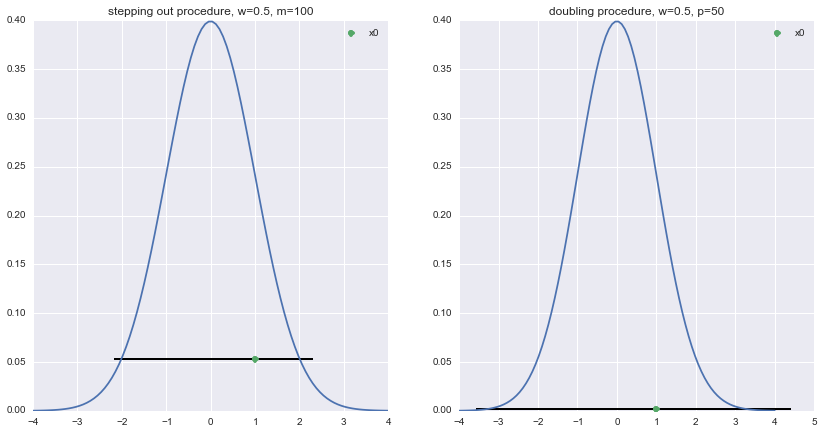

In [2]:
f = ss.norm.pdf
x0 = np.array([1])
w = 0.5
m = 100
p = 50

L1, R1, y1 = I_stepping_out(f, x0, w, m)
L2, R2, y2 = I_doubling(f, x0, w, p)

# viz
X = np.linspace(-4, 4, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].plot(X, f(X))
axes[1].plot(X, f(X))

axes[0].hlines(y1, L1, R1, lw=2)
axes[0].plot(x0, y1, 'o', label='x0')
axes[1].hlines(y2, L2, R2, lw=2)
axes[1].plot(x0, y2, 'o', label='x0')

axes[0].set_title("stepping out procedure, w={}, m={}".format(w, m))
axes[1].set_title("doubling procedure, w={}, p={}".format(w, p))
axes[0].legend()
axes[1].legend()

###  Sampling

Now we use slice sampler to estimate the density:

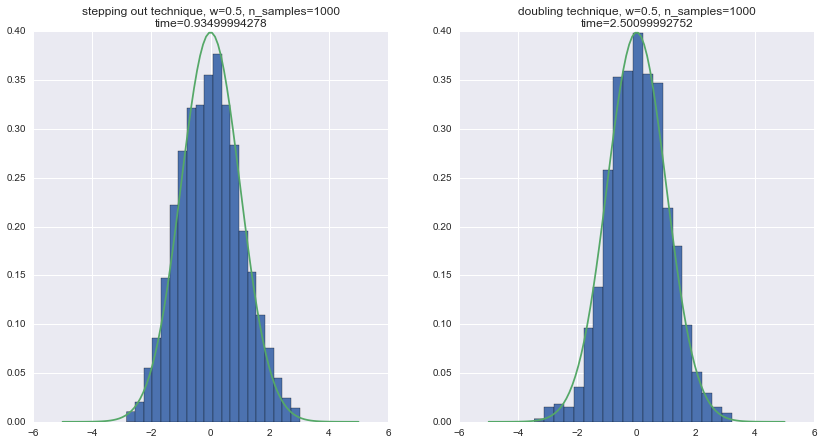

In [4]:
f = ss.norm.pdf

n_samples = 1000
x0 = np.array([0])
w = 0.5
m = 50
p = 20

tic = time()
samples1 = slice_sampler(f, x0, n_samples, w=w, m=m, doubling=False)                  # stepping out
elapsed1 = time() - tic
tic = time()
samples2 = slice_sampler(f, x0, n_samples, w=w, p=p, doubling=True)                   # doubling
elapsed2 = time() - tic

# visualization
X = np.linspace(-5, 5, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].hist(samples1, bins=20, normed=True)
axes[0].plot(X, f(X))
axes[0].set_title("stepping out technique, w={}, n_samples={}\ntime={}".format(w, n_samples, elapsed1))
axes[1].hist(samples2, bins=20, normed=True)
axes[1].plot(X, f(X))
axes[1].set_title("doubling technique, w={}, n_samples={}\ntime={}".format(w, n_samples, elapsed2))

# Multimodal densities

$$q=0.2\mathcal{N}\left(3,1\right)+0.8N\left(10,2\right)$$

In [5]:
mu1 = 3
mu2 = 10
sigma1 = 1
sigma2 = 2
m1 = 0.2
m2 = 0.8

f = lambda x: m1 * ss.norm.pdf(x, mu1, sigma1) + m2 * ss.norm.pdf(x, mu2, sigma2)

### Plotting the interval

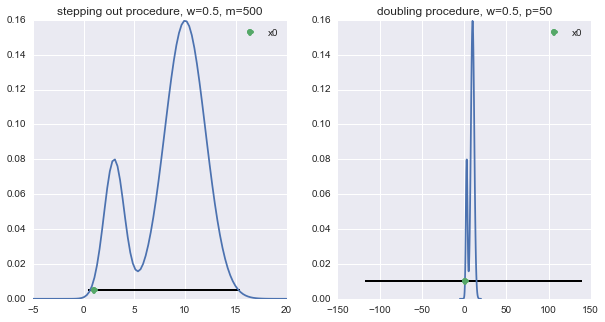

In [6]:
x0 = np.array([1])
w = 0.5
m = 500
p = 50

L1, R1, y1 = I_stepping_out(f, x0, w, m)
L2, R2, y2 = I_doubling(f, x0, w, p)

X = np.linspace(-5, 20, 100)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(X, f(X))
axes[1].plot(X, f(X))

axes[0].hlines(y1, L1, R1, lw=2)
axes[0].plot(x0, y1, 'o', label='x0')
axes[1].hlines(y2, L2, R2, lw=2)
axes[1].plot(x0, y2, 'o', label='x0')

axes[0].set_title("stepping out procedure, w={}, m={}".format(w, m))
axes[1].set_title("doubling procedure, w={}, p={}".format(w, p))
axes[0].legend()
axes[1].legend()

### Sampling

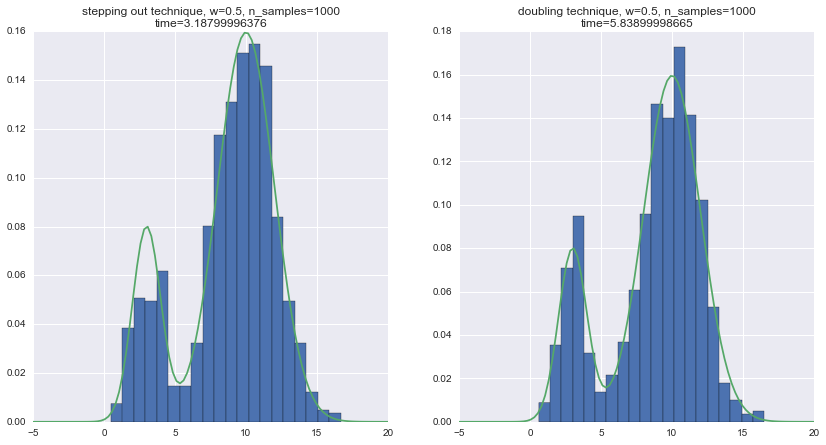

In [8]:
n_samples = 1000
x0 = np.array([0])
w = 0.5
m = 50
p = 20

tic = time()
samples1 = slice_sampler(f, x0, n_samples, w=w, m=m, doubling=False)                  # stepping out
elapsed1 = time() - tic
tic = time()
samples2 = slice_sampler(f, x0, n_samples, w=w, p=p, doubling=True)                   # doubling
elapsed2 = time() - tic

# visualization
X = np.linspace(-5, 20, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].hist(samples1, bins=20, normed=True)
axes[0].plot(X, f(X))
axes[0].set_title("stepping out technique, w={}, n_samples={}\ntime={}".format(w, n_samples, elapsed1))
axes[1].hist(samples2, bins=20, normed=True)
axes[1].plot(X, f(X))
axes[1].set_title("doubling technique, w={}, n_samples={}\ntime={}".format(w, n_samples, elapsed2))

What if the two Gaussians are further from each other? As the interval figures below show, stepping out method will probably not work.

$$q=0.2\mathcal{N}\left(0,1\right)+0.8N\left(20,2\right)$$

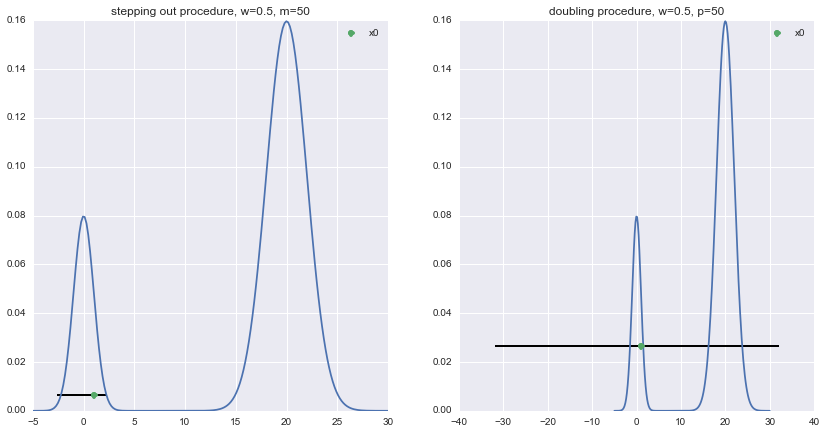

In [16]:
mu1 = 0
mu2 = 20
sigma1 = 1
sigma2 = 2
m1 = 0.2
m2 = 0.8

f = lambda x: m1 * ss.norm.pdf(x, mu1, sigma1) + m2 * ss.norm.pdf(x, mu2, sigma2)

# Plotting the interval I 
x0 = np.array([1])
w = 0.5
m = 50
p = 50

L1, R1, y1 = I_stepping_out(f, x0, w, m)
L2, R2, y2 = I_doubling(f, x0, w, p)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

X = np.linspace(-5, 30, 200)

axes[0].plot(X, f(X))
axes[1].plot(X, f(X))

axes[0].hlines(y1, L1, R1, lw=2)
axes[0].plot(x0, y1, 'o', label='x0')
axes[1].hlines(y2, L2, R2, lw=2)
axes[1].plot(x0, y2, 'o', label='x0')

axes[0].set_title("stepping out procedure, w={}, m={}".format(w, m))
axes[1].set_title("doubling procedure, w={}, p={}".format(w, p))
axes[0].legend()
axes[1].legend()

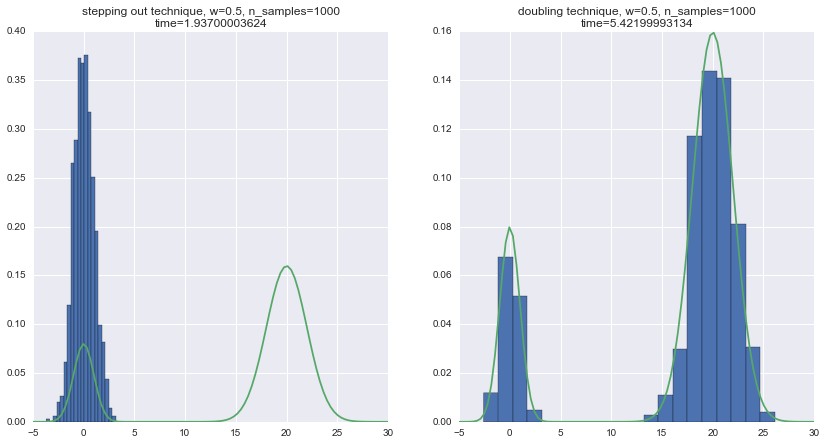

In [18]:
n_samples = 1000
x0 = np.array([0])
w = 0.5
m = 50
p = 20

tic = time()
samples1 = slice_sampler(f, x0, n_samples, w=w, m=m, doubling=False)                  # stepping out
elapsed1 = time() - tic
tic = time()
samples2 = slice_sampler(f, x0, n_samples, w=w, p=p, doubling=True)                   # doubling
elapsed2 = time() - tic

# visualization
X = np.linspace(-5, 30, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].hist(samples1, bins=20, normed=True)
axes[0].plot(X, f(X))
axes[0].set_title("stepping out technique, w={}, n_samples={}\ntime={}".format(w, n_samples, elapsed1))
axes[1].hist(samples2, bins=20, normed=True)
axes[1].plot(X, f(X))
axes[1].set_title("doubling technique, w={}, n_samples={}\ntime={}".format(w, n_samples, elapsed2))

Can we get it right by tweaking $w$?

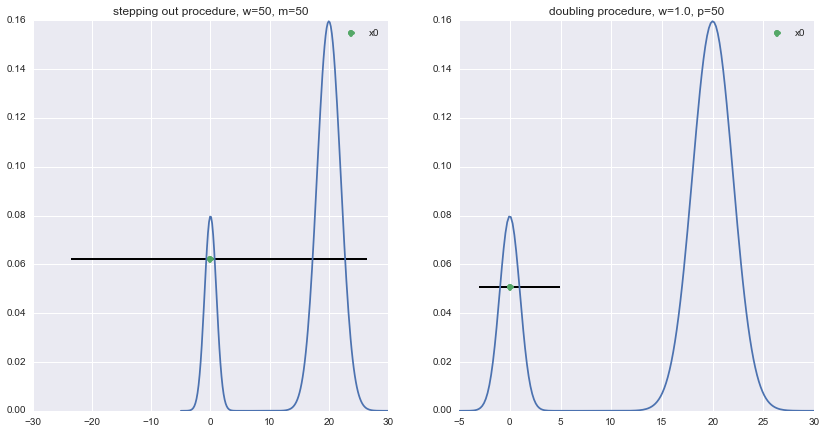

In [25]:
mu1 = 0
mu2 = 20
sigma1 = 1
sigma2 = 2
m1 = 0.2
m2 = 0.8

f = lambda x: m1 * ss.norm.pdf(x, mu1, sigma1) + m2 * ss.norm.pdf(x, mu2, sigma2)

# Plotting the interval I 
x0 = np.array([0])
w1 = 50
w2 = 1.0
m = 50
p = 50

L1, R1, y1 = I_stepping_out(f, x0, w1, m)
L2, R2, y2 = I_doubling(f, x0, w2, p)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

X = np.linspace(-5, 30, 200)

axes[0].plot(X, f(X))
axes[1].plot(X, f(X))

axes[0].hlines(y1, L1, R1, lw=2)
axes[0].plot(x0, y1, 'o', label='x0')
axes[1].hlines(y2, L2, R2, lw=2)
axes[1].plot(x0, y2, 'o', label='x0')

axes[0].set_title("stepping out procedure, w={}, m={}".format(w1, m))
axes[1].set_title("doubling procedure, w={}, p={}".format(w2, p))
axes[0].legend()
axes[1].legend()

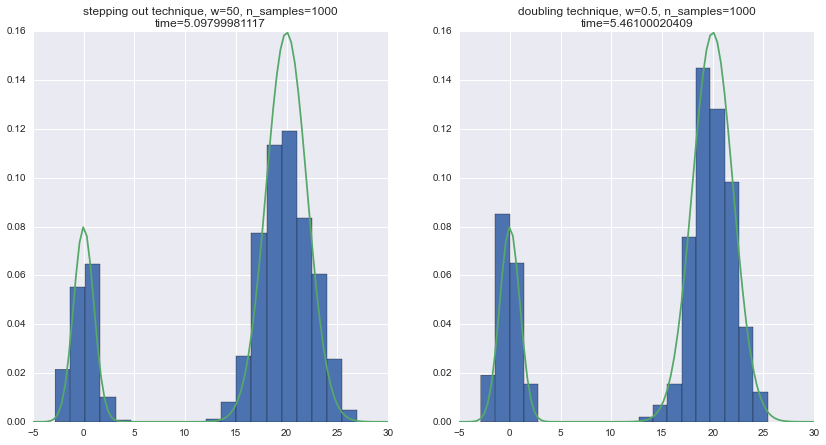

In [26]:
n_samples = 1000
x0 = np.array([0])
w1 = 50
w2 = 0.5
m = 50
p = 20

tic = time()
samples1 = slice_sampler(f, x0, n_samples, w=w1, m=m, doubling=False)                  # stepping out
elapsed1 = time() - tic
tic = time()
samples2 = slice_sampler(f, x0, n_samples, w=w2, p=p, doubling=True)                   # doubling
elapsed2 = time() - tic

# visualization
X = np.linspace(-5, 30, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].hist(samples1, bins=20, normed=True)
axes[0].plot(X, f(X))
axes[0].set_title("stepping out technique, w={}, n_samples={}\ntime={}".format(w1, n_samples, elapsed1))
axes[1].hist(samples2, bins=20, normed=True)
axes[1].plot(X, f(X))
axes[1].set_title("doubling technique, w={}, n_samples={}\ntime={}".format(w2, n_samples, elapsed2))

### <span style="color:red">But the question is thi: How can we choose an appropriate value for w (and also other parameters m, p)?</span>

# Multi-dimensional densities

Now we use slice sampling to sample from a multi-dimensional distribution, a 2-dimensional Gaussian.

$\mu = 
\begin{bmatrix}
1\\
5
\end{bmatrix}
$
,
$\Sigma = 
\begin{bmatrix}
2 & 0.5\\
0.5 & 1
\end{bmatrix}
$
, $q=\mathcal{N}\left(\mu, \Sigma\right)$

There are two methods for slice sampling Multi-dimensional distributions. 

1. Similar to Gibbs sampling we derive conditional distributions and then slice sample single variables separately. (Unlike Gibbs sampling, conditional distributions can be non-standard forms, as long as we can evaluate the density on a the domain.)
2. Instead of slicing rectangles that lead to method one (single variable slice sampling), generalize the slice to a hyper-rectangle.

<matplotlib.contour.QuadContourSet instance at 0x00000000243CA188>

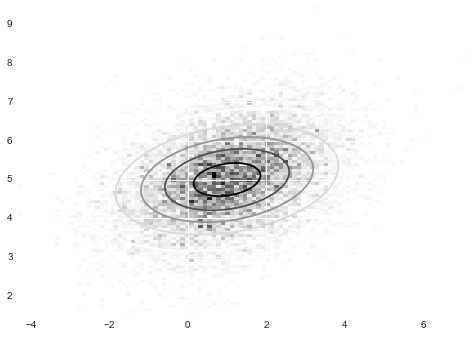

In [28]:
mu = [1, 5]
cov = [[2, 0.5], [0.5, 1]]
samples = np.random.multivariate_normal(mu, cov, size=10000)

x = np.linspace(-4, 6, 100)
y = np.linspace(0, 8, 100)
X, Y = np.meshgrid(x, y)
Z = mlab.bivariate_normal(X, Y, 2, 1, 1, 5, 0.5)

fig, ax = plt.subplots()
ax.hist2d(samples[:, 0], samples[:, 1], bins=100)
ax.contour(X, Y, Z)

## Single variable slice sampling

In [29]:
f = ss.multivariate_normal(mu, cov).pdf

In [27]:
x0 = 1
y0 = 1

n_samples = 10000
samples1 = np.zeros((n_samples, 2))
samples2 = np.zeros((n_samples, 2))
w = 0.5
p = 20
m = 50

tic = time()
for i in xrange(n_samples):

    # sampling x
    fx = lambda x: f((x, y0))
    x0 = np.array([x0])
    x1 = slice_sampler(fx, x0, 1, w, p=p, doubling=True)
    x0 = x1[0][0]
    samples1[i, 0] = x0
    
    # sampling y
    fy = lambda y: f((x0, y))
    y0 = np.array([y0])
    y1 = slice_sampler(fy, y0, 1, w, p=p, doubling=True)
    y0 = y1[0][0]
    samples1[i, 1] = y0    
elapsed1 = time() - tic    
    
tic = time()    
for i in xrange(n_samples):

    # sampling x
    fx = lambda x: f((x, y0))
    x0 = np.array([x0])
    x1 = slice_sampler(fx, x0, 1, w, m=m, doubling=False)
    x0 = x1[0][0]
    samples2[i, 0] = x0
    
    # sampling y
    fy = lambda y: f((x0, y))
    y0 = np.array([y0])
    y1 = slice_sampler(fy, y0, 1, w, m=m, doubling=False)
    y0 = y1[0][0]
    samples2[i, 1] = y0
elapsed2 = time() - tic    

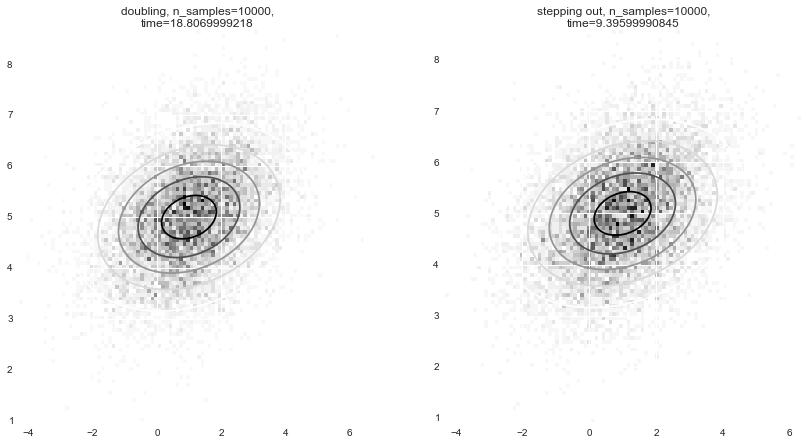

In [28]:
#Visualization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

axes[0].hist2d(samples1[:, 0], samples1[:, 1], bins=100)
axes[0].contour(X, Y, Z)
axes[0].set_title("doubling, n_samples={},\ntime={}".format(n_samples, elapsed1))

axes[1].hist2d(samples2[:, 0], samples2[:, 1], bins=100)
axes[1].contour(X, Y, Z)
axes[1].set_title("stepping out, n_samples={},\ntime={}".format(n_samples, elapsed2))

## Hyperrectangle

In [29]:
mu = [1, 5]
cov = [[2, 0.5], [0.5, 1]]
f = ss.multivariate_normal(mu, cov).pdf
samples = np.random.multivariate_normal(mu, cov, size=10000)

x = np.linspace(-4, 6, 100)
y = np.linspace(0, 8, 100)
X, Y = np.meshgrid(x, y)
Z = mlab.bivariate_normal(X, Y, 2, 1, 1, 5, 0.5)

In [38]:
x0 = np.array([1, 1])

w = 0.5
m = 50
p = 20
n_samples = 10000

tic = time()
samples1 = slice_sampler(f, x0, n_samples, w, m=m, doubling=False, all_dim=True)
elapsed1 = time() - tic

tic = time()
samples2 = slice_sampler(f, x0, n_samples, w, m=m, doubling=False, all_dim=False)
elapsed2 = time() - tic

tic = time()
samples3 = slice_sampler(f, x0, n_samples, w, p=p, doubling=True, all_dim=True)
elapsed3 = time() - tic

tic = time()
samples4 = slice_sampler(f, x0, n_samples, w, p=p, doubling=True, all_dim=False)
elapsed4 = time() - tic

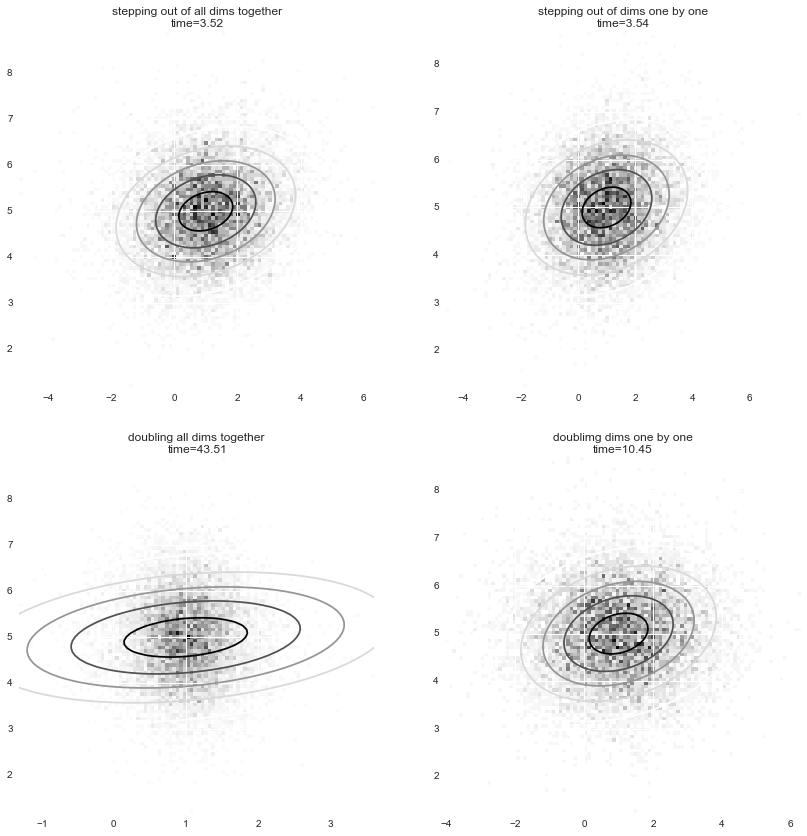

In [39]:
#Visualization
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

axes[0, 0].hist2d(samples1[:, 0], samples1[:, 1], bins=100)
axes[0, 0].contour(X, Y, Z)
axes[0, 0].set_title("stepping out of all dims together\ntime={0:.2f}".format(elapsed1))

axes[0, 1].hist2d(samples2[:, 0], samples2[:, 1], bins=100)
axes[0, 1].contour(X, Y, Z)
axes[0, 1].set_title("stepping out of dims one by one\ntime={0:.2f}".format(elapsed2))

axes[1, 0].hist2d(samples3[:, 0], samples1[:, 1], bins=100)
axes[1, 0].contour(X, Y, Z)
axes[1, 0].set_title("doubling all dims together\ntime={0:.2f}".format(elapsed3))

axes[1, 1].hist2d(samples4[:, 0], samples2[:, 1], bins=100)
axes[1, 1].contour(X, Y, Z)
axes[1, 1].set_title("doublimg dims one by one\ntime={0:.2f}".format(elapsed4))